# Machine Learning 

In [130]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
from collections import Counter


# Load the data
X_train= pd.read_csv("../train/pheno_training_treated.csv")
X_train.drop(columns=["Sample_ID"], inplace=True)
y_train = X_train.PrevalentHFAIL + X_train.Event# data target with the patients that had HF before and after the first data collecting
y_train = y_train.map({2: 1, 0: 0, 1: 1})
X_train.drop(columns=[ "PrevalentHFAIL","Event"], inplace=True)



X_test = pd.read_csv("../test/pheno_test_treated.csv")
X_test.drop(columns=["Sample_ID"], inplace=True)
y_test = X_test.PrevalentHFAIL  # data target with the patients that had HF before and after the first data collecting
y_test = y_test.map({2: 1, 0: 0, 1: 1})
X_test.drop(columns=[ "PrevalentHFAIL","Event"], inplace=True)


print('Original dataset shape %s' % Counter(y_train))
# SMOTE is used in unbalanced datasets to balance it
sm = SMOTE(random_state=42)
X_train, y_train = sm.fit_resample(X_train, y_train)

print('Resampled dataset shape %s' % Counter(y_train))


Original dataset shape Counter({0: 3229, 1: 386})
Resampled dataset shape Counter({0: 3229, 1: 3229})


C:\Users\35193\AppData\Local\Temp\ipykernel_10524\1935292392.py:9: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


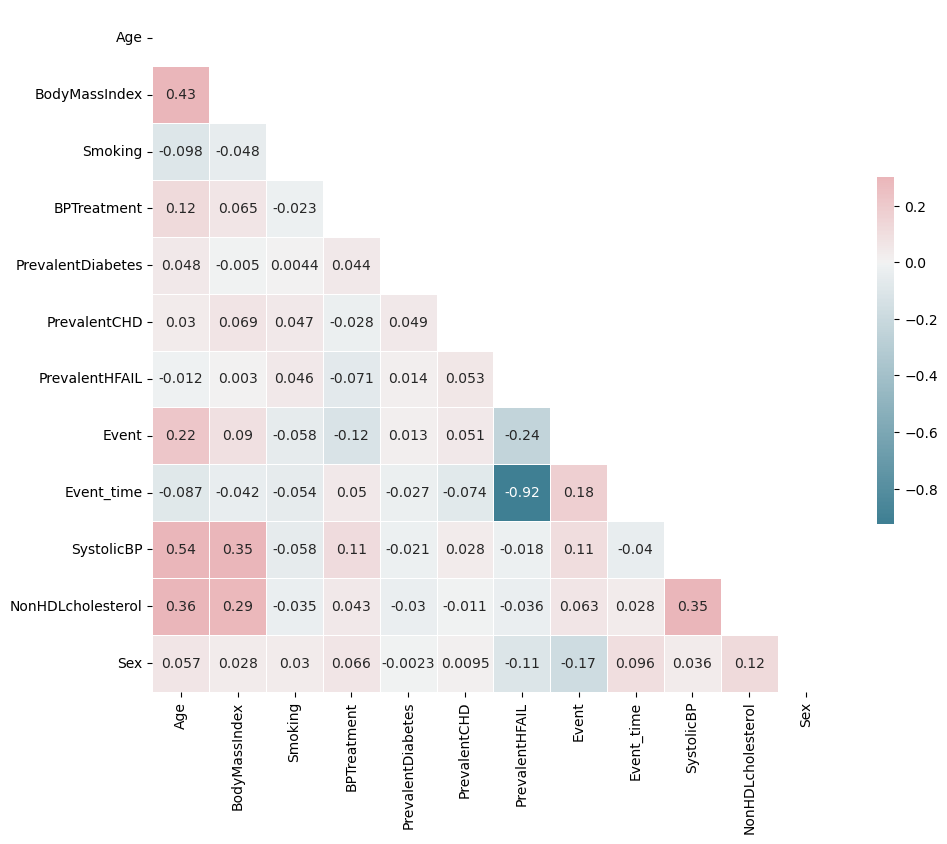

In [129]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the correlation matrix
X_train = pd.DataFrame(X_train)
corr = X_train.corr()

# Create a mask to hide the upper triangle of the correlation matrix (redundant information)
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, annot=True, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()


In [131]:
from sklearn.feature_selection import SelectKBest

selector = SelectKBest(k=7)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_select = selector.transform(X_test)

# Get the selected features
selected_features = X_train.columns[selector.get_support()]

# Print the selected features
print(selected_features)

Index(['Age', 'BodyMassIndex', 'BPTreatment', 'PrevalentCHD', 'Event_time',
       'SystolicBP', 'Sex'],
      dtype='object')


In [132]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# data preparation
X_train = X_train.loc[:, selected_features]

X_test = X_test.loc[:, selected_features]



PECC accuracy: 0.58595909342178


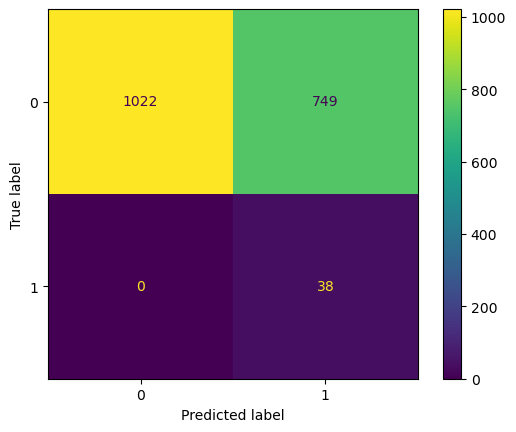

              precision    recall  f1-score   support

           0       1.00      0.58      0.73      1771
           1       0.05      1.00      0.09        38

    accuracy                           0.59      1809
   macro avg       0.52      0.79      0.41      1809
weighted avg       0.98      0.59      0.72      1809



In [144]:
# Standardize data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

# Initialize the model
clf = LogisticRegression(C=1e5, solver = "liblinear", multi_class = "auto")

# Fit the model to the training data
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Calculate the PECC accuracy
pec_acc = (y_test == y_pred).mean()
print("PECC accuracy:", pec_acc)

# Plot the confusion matrix
cm_logreg = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm_logreg, display_labels=clf.classes_)
disp1.plot()
plt.show()

# print the classification report
print(classification_report(y_test, y_pred))

In [140]:
y_pred_df = pd.DataFrame(y_pred, columns=["A"])
y_pred_df.loc[y_pred_df["A"] == 1.0]

,A
1,1
5,1
9,1
11,1
12,1
...,...
1802,1
1804,1
1805,1
1806,1


In [141]:
from sklearn.svm import SVC

# Initialize the model
clf = SVC(kernel="linear", random_state=42)

# Fit the model to the training data
clf.fit(X_train, y_train)

# Make predictions on the test data
y_pred = clf.predict(X_test)

# Evaluate the model's performance
accuracy = clf.score(X_test, y_test)
print("Accuracy: ", accuracy)


Accuracy:  0.5726920950801547
